In [3]:
import pywt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [4]:
# 라이브러리로 CIFAR-10 데이터셋 불러오기 (torchvision 사용)
import torchvision
import torchvision.transforms as transforms
import numpy as np

# 데이터 정규화: 0~1 범위로 변환
transform = transforms.Compose([
    transforms.ToTensor(),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# data normalization
X_train = trainset.data.astype(np.float32) / 255.0  # shape (50000, 32, 32, 3)
y_train = np.array(trainset.targets) # 라벨
X_test = testset.data.astype(np.float32) / 255.0
y_test = np.array(testset.targets)

## DWT 모든 성분/ low-pass, 저주파만 사용 비교

In [5]:
# DWT 계수를 한 번에 계산하고 필요에 따라 특징을 추출하는 함수
def extract_dwt_features(img):
    """
    이미지에 대해 DWT를 한 번만 계산하고, 
    근사(LL) 계수와 모든(LL, LH, HL, HH) 계수를 모두 반환합니다.
    """
    all_coeffs = []
    approx_coeffs = []
    for c in range(3):
        cA, (cH, cV, cD) = pywt.dwt2(img[:, :, c], "haar")
        
        # 근사 계수(LL)
        approx_coeffs.append(cA.flatten())
        
        # 모든 계수 (LL, LH, HL, HH)
        all_coeffs.extend([cA.flatten(), cH.flatten(), cV.flatten(), cD.flatten()])
        
    return np.concatenate(approx_coeffs), np.concatenate(all_coeffs)

In [6]:
results_train = [extract_dwt_features(img) for img in X_train] # 저주파, 전부 특성 pair 있는 리스트
X_train_dwt_approx, X_train_dwt_all = zip(*results_train) #zip으로 분리

results_test = [extract_dwt_features(img) for img in X_test]
X_test_dwt_approx, X_test_dwt_all = zip(*results_test)

# 리스트를 numpy 배열로 변환
X_train_dwt_approx = np.array(X_train_dwt_approx)
X_train_dwt_all = np.array(X_train_dwt_all)
X_test_dwt_approx = np.array(X_test_dwt_approx)
X_test_dwt_all = np.array(X_test_dwt_all)

In [9]:
from sklearn.pipeline import Pipeline

# PCA 및 kNN 평가 함수
def evaluate_pca_knn(X_train, X_test, y_train, y_test, n_components) :# n_component로 눈에 띄는 상위 n개 성분만 
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    knn = KNeighborsClassifier(n_neighbors=7, metric="euclidean")
    knn.fit(X_train_pca, y_train)
    y_pred = knn.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

pca_knn_pipeline = Pipeline([
    ('pca', PCA(n_components=20)),
    ('knn', KNeighborsClassifier(n_neighbors=1))
])

In [ ]:
# 두 방식의 정확도 비교
acc_approx = evaluate_pca_knn(X_train_dwt_approx, X_test_dwt_approx, y_train, y_test, n_components=20)
print(f"근사값만 사용 정확도: {acc_approx * 100:.2f}%")

acc_all = evaluate_pca_knn(X_train_dwt_all, X_test_dwt_all, y_train, y_test, n_components=20)
print(f"모든 성분 사용 정확도: {acc_all * 100:.2f}%")

근사값만 사용 정확도: 40.15%
모든 성분 사용 정확도: 40.23%
모든 성분 사용 정확도: 40.23%


In [10]:
from sklearn.model_selection import GridSearchCV
k_range = range(1, 35)

grid_params = {
    'knn__n_neighbors' : k_range
}
scoring_metrics = ["accuracy", "precision_macro", "recall_macro", "f1_macro"]

grid_search = GridSearchCV(pca_knn_pipeline, grid_params, cv = 5, scoring=scoring_metrics, refit='accuracy')
grid_search.fit(X_train_dwt_all, y_train)

,estimator,Pipeline(step...eighbors=1))])
,param_grid,"{'knn__n_neighbors': range(1, 35)}"
,scoring,"['accuracy', 'precision_macro', ...]"
,n_jobs,None
,refit,'accuracy'
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_components,20


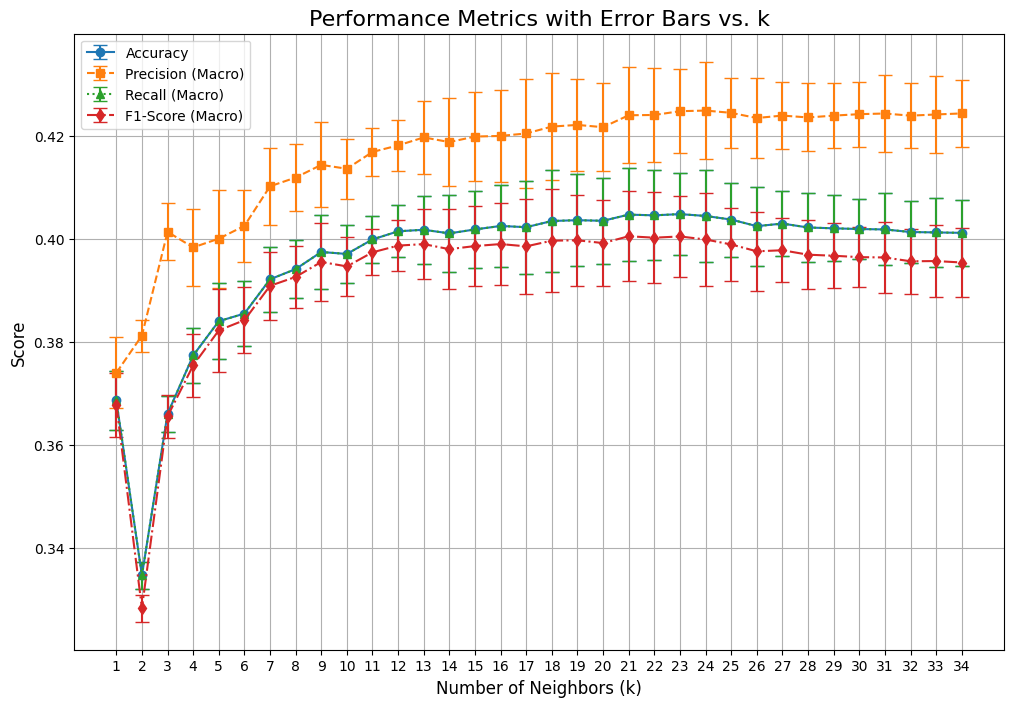

In [ ]:
from matplotlib import pyplot as plt

results= grid_search.cv_results_
k_values = results['param_knn__n_neighbors'].data.astype(int)

mean_accuracy = results["mean_test_accuracy"]
mean_precision = results["mean_test_precision_macro"]
mean_recall = results["mean_test_recall_macro"]
mean_f1 = results["mean_test_f1_macro"]

std_accuracy = results["std_test_accuracy"]
std_precision = results["std_test_precision_macro"]
std_recall = results["std_test_recall_macro"]
std_f1 = results["std_test_f1_macro"]

plt.figure(figsize=(12, 8))

plt.errorbar(
    k_values, mean_accuracy, yerr=std_accuracy, marker="o", capsize=5, label="Accuracy"
)
plt.errorbar(
    k_values,
    mean_precision,
    yerr=std_precision,
    marker="s",
    capsize=5,
    linestyle="--",
    label="Precision (Macro)",
)
plt.errorbar(
    k_values,
    mean_recall,
    yerr=std_recall,
    marker="^",
    capsize=5,
    linestyle=":",
    label="Recall (Macro)",
)
plt.errorbar(
    k_values,
    mean_f1,
    yerr=std_f1,
    marker="d",
    capsize=5,
    linestyle="-.",
    label="F1-Score (Macro)",
)

# 3. 그래프 꾸미기
plt.title("Performance Metrics with Error Bars vs. k", fontsize=16)
plt.xlabel("Number of Neighbors (k)", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.show()